# Importing Modules

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm




from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict

# Importing Hourly File

In [16]:
hbike = pd.read_csv('/Users/flo/Documents/IE/ML/Bike-Sharing-Dataset/hour.csv', sep=',')
hbike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# General Information

In [17]:
hbike = hbike.drop('instant',1)
hbike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 2.1+ MB


# Exploratory Data Observations

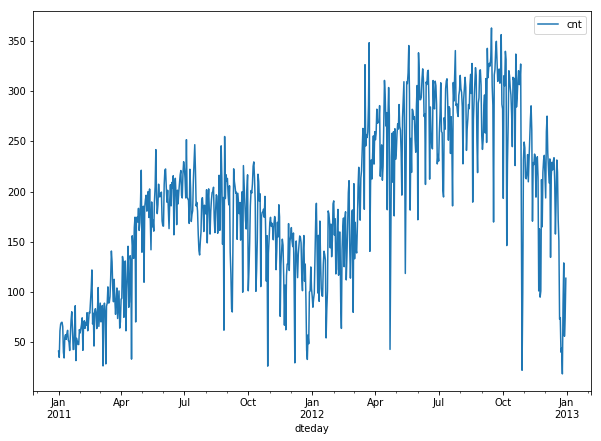

In [18]:
#Converting to Date to get general Shape of predictions 
#--> Real Life assumptions (more in the summer, less in the winter)
#--> Thee seems to be a natural increase from 2011 to 2012
hbike['dteday'] = pd.to_datetime(hbike.dteday)

hbike[['dteday', 'cnt']].groupby(['dteday']).agg('mean').plot(figsize=(10,7))

# Outlier Analysis

[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count/Working Day Distribution')]

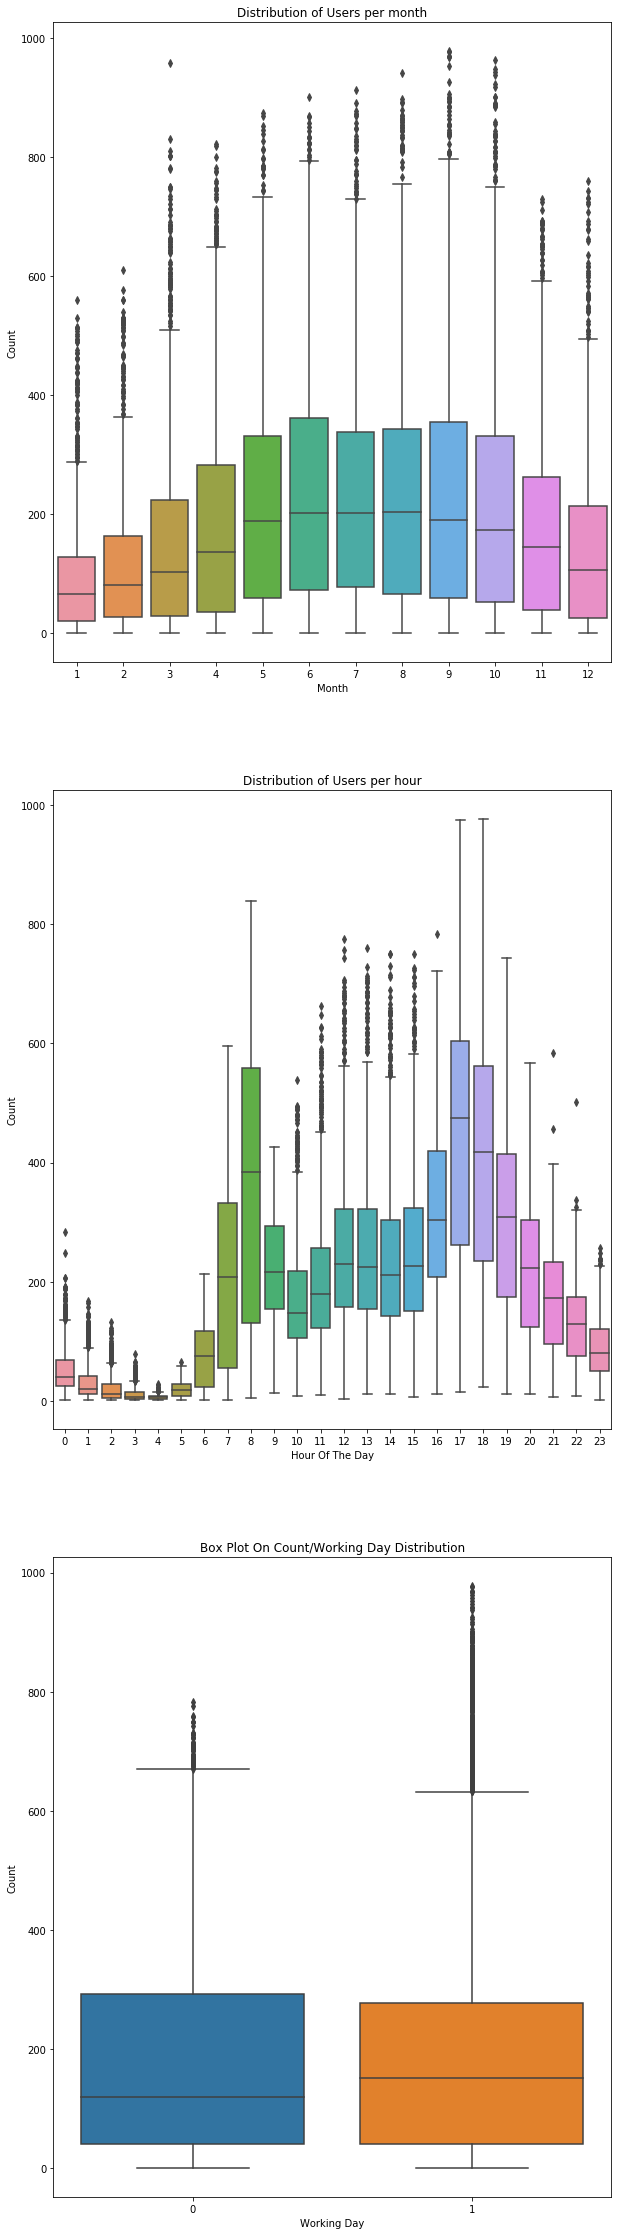

In [19]:
fig, axes = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(10, 40)

sns.boxplot(data=hbike,y="cnt",x="mnth",orient="v",ax=axes[0])
axes[0].set(xlabel='Month', ylabel='Count',title="Distribution of Users per month")

sns.boxplot(data=hbike,y="cnt",x="hr",orient="v",ax=axes[1])
axes[1].set(xlabel='Hour Of The Day', ylabel='Count',title="Distribution of Users per hour")

sns.boxplot(data=hbike,y="cnt",x="workingday",orient="v",ax=axes[2])
axes[2].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count/Working Day Distribution")

# Correlation Analysis

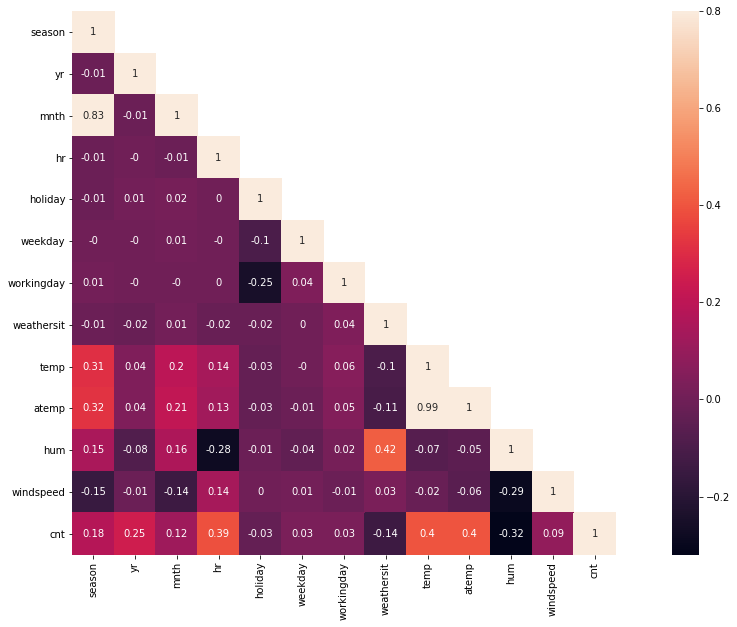

In [20]:
#Dropping these as we want to predict totals 

hbike = hbike.drop('casual',1)
hbike = hbike.drop('registered',1)



corrMatt = hbike.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt.round(2), mask=mask,vmax=.8, square=True,annot=True)

# Feature Engineering

In [21]:
Xraw = hbike[['yr','hr','season','workingday','atemp','windspeed','holiday','weathersit']] # Initial Choice


#One Hot Encoding of categorical values

ohe = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipec = Pipeline([ohe])
Xc = hbike[['season','weathersit','hr']]
Xct = pd.DataFrame(pipec.fit_transform(Xc))
Xraw = Xraw.drop('weathersit', 1)
Xraw = Xraw.drop('season', 1)
Xraw = Xraw.drop('hr', 1)

X = pd.concat([Xraw,Xct],axis=1,sort=False)
y = hbike[['cnt']]

X.head()


,yr,workingday,atemp,windspeed,holiday,0,1,2,3,4,...,22,23,24,25,26,27,28,29,30,31
0,0,0,0.2879,0.0,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0.2727,0.0,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.2727,0.0,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.2879,0.0,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.2879,0.0,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [22]:
#Modelling

cvStrategy = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = 'r2'
model = RandomForestRegressor(n_estimators=500, n_jobs=-1)
#model = linear_model.Ridge()
#model = svm.SVR(kernel='linear', C=1000)
#model = linear_model.Lasso()
#model = linear_model.Ridge()
#model = linear_model.Ridge()
scores = cross_val_score(model, X, y.values.flatten(), cv=cvStrategy, scoring=scoring)
print(scores)
print(np.average(scores))


[0.90398634 0.91203602 0.91018482 0.91905269 0.91270972 0.92046103]
0.9130717688295062


# Visualization - Prediction for Year 2

Splitting Data Set in Year 1 and 2

In [23]:
Xraw2 = hbike[['yr','hr','season','workingday','atemp','windspeed','holiday','weathersit','cnt']]
Xraw3 = hbike[['dteday','yr','hr','season','workingday','atemp','windspeed','holiday','weathersit','cnt']]
FinalCUT = Xraw3[Xraw3['yr']==1].reset_index()

TestRaw = Xraw2[Xraw2['yr']==1].reset_index()
TestRaw = TestRaw.drop('yr', 1)
TestRaw = TestRaw.drop('index', 1)
TestRaw2 = TestRaw.drop('cnt', 1)


TrainRaw = Xraw2[Xraw2['yr']==0]
TrainRaw = TrainRaw.drop('yr', 1)
TrainRaw2 = TrainRaw.drop('cnt', 1)

#Predicting for year 1:

ohe = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipec = Pipeline([ohe])
Xc = TrainRaw2[['season','weathersit','hr']]
Xct = pd.DataFrame(pipec.fit_transform(Xc))
TrainRaw2 = TrainRaw2.drop('weathersit', 1)
TrainRaw2 = TrainRaw2.drop('season', 1)
TrainRaw2 = TrainRaw2.drop('hr', 1)

X1 = pd.concat([TrainRaw2,Xct],axis=1,sort=False)
y1 = TrainRaw[['cnt']]

ohe = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipec = Pipeline([ohe])
Xc2 = TestRaw2[['season','weathersit','hr']]
Xct2 = pd.DataFrame(pipec.fit_transform(Xc2))
TestRaw2 = TestRaw2.drop('weathersit', 1)
TestRaw2 = TestRaw2.drop('season', 1)
TestRaw2 = TestRaw2.drop('hr', 1)


X2 = pd.concat([TestRaw2,Xct2],axis=1,sort=False)
y2 = TestRaw[['cnt']]

# Predictions Year 2

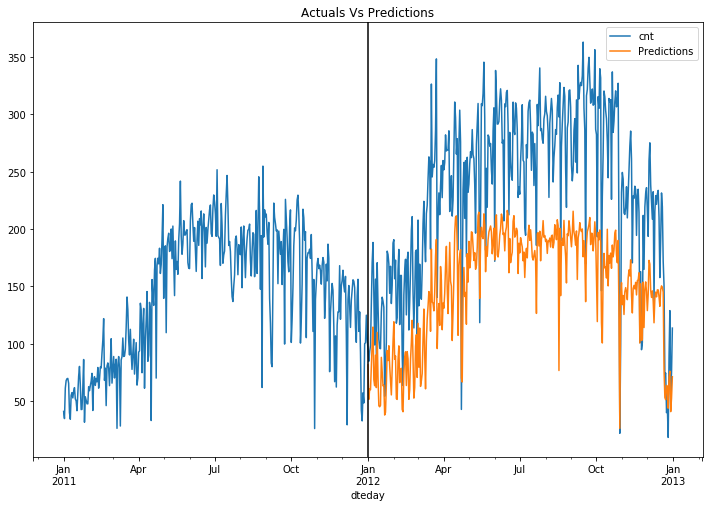

In [27]:

model_test = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_test.fit(X1,y1.values.flatten())
predictions_year1 = model_test.predict(X2)

predicts1 = pd.DataFrame(predictions_year1,columns=['Predictions'],dtype=float)

Final = pd.concat([FinalCUT,predicts1],axis=1,sort=False)


ax = hbike[['dteday', 'cnt']].groupby(['dteday']).agg('mean').plot()
Final[['dteday', 'Predictions']].groupby(['dteday']).agg('mean').plot(ax=ax,title="Actuals Vs Predictions",figsize=(12,8))
plt.axvline(x=pd.Timestamp('2012-01-01 00:00:00'),color="black")